# **Human Value Detection - SemEval 2023**
## **ValueEval: Identification of Human Values behind Arguments**

### **Natural Language Processing**

### **Task**

The aim of this project is to provide a solution to the multi-label **Human Value Detection** problem from [Touché SemEval 2023 Task 4](https://touche.webis.de/semeval23/touche23-web/index.html): *ValueEval - Identification of Human Values behind Arguments*.

Given a textual argument and a human value category, the goal is to classify whether or not the argument draws on that category. This task uses a set of 20 human value categories compiled from the social science literature and described in the paper [Identifying the Human Values behind Arguments](https://webis.de/downloads/publications/papers/kiesel_2022b.pdf).

The arguments are given as:
- premise text
- conclusion text
- binary stance of the premise to the conclusion: "*in favor of*" or "*against*"

### Import libraries and initial settings



In [ ]:
!pip install contractions
!pip install nltk
!pip install spacy
!pip install transformers==4.28.1
!pip install datasets
!pip install evaluate

In [2]:
import os
import re
import sys
import random
import string
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datasets
from datasets import Features, Value, Sequence

from google.colab import drive, files

import torch

import nltk
from nltk.corpus import stopwords
import spacy #lemmatization
import contractions
from statistics import mean

import sklearn.metrics
from sklearn.utils import shuffle
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.metrics import f1_score, roc_auc_score, classification_report, ConfusionMatrixDisplay, multilabel_confusion_matrix
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier

from transformers import AutoModelForSequenceClassification, AutoTokenizer, EvalPrediction, Trainer, TrainingArguments
from transformers.modeling_outputs import SequenceClassifierOutput

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
random_seed = 42

def set_reproducibility(seed):
    """
    Set a random seed for reproducibility

    :param seed: random seed
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'

set_reproducibility(random_seed)

In [5]:
# folder where the project files are located
drive_path = 'drive/MyDrive/ProjectNLP/'

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Data loading and Dataframe creation



In [7]:
# path where the .tsv data files for training, validation and test are stored
data_path = 'data/'

In [8]:
def create_dataframe_split(path, split):
  ''' Creates a dataframe for the arguments and the labels
  given the file path and the split

  :param path: path where the dataset files are located
  :param split: dataset split

  :return arguments_df: dataframe with arguments
  :return labels_df: dataframe with labels
  '''
  arguments_df = pd.read_csv(path + data_path + 'arguments-' + split + '.tsv', sep='\t')
  labels_df = pd.read_csv(path + data_path + 'labels-' + split + '.tsv', sep='\t')
  labels = [labels_df.iloc[i].to_numpy()[1:] for i in range(len(arguments_df))]
  arguments_df['labels'] = labels

  return arguments_df, labels_df

In [9]:
# create dataframes for each dataset split and related labels
df_train, train_labels = create_dataframe_split(drive_path, 'training')
df_val, val_labels = create_dataframe_split(drive_path, 'validation')
df_test, test_labels = create_dataframe_split(drive_path, 'test')

Showing some training set examples of arguments premise, stance and conclusion and the corresponding labels

In [10]:
df_train

,Argument ID,Conclusion,Stance,Premise,labels
0,A01002,We should ban human cloning,in favor of,we should ban human cloning as it will only ca...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
1,A01005,We should ban fast food,in favor of,fast food should be banned because it is reall...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
2,A01006,We should end the use of economic sanctions,against,sometimes economic sanctions are the only thin...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
3,A01007,We should abolish capital punishment,against,capital punishment is sometimes the only optio...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, ..."
4,A01008,We should ban factory farming,against,factory farming allows for the production of c...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, ..."
...,...,...,...,...,...
5388,E08016,The EU should integrate the armed forces of it...,in favor of,"On the one hand, we have Russia killing countl...","[0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
5389,E08017,Food whose production has been subsidized with...,in favor of,The subsidies were originally intended to ensu...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, ..."
5390,E08018,Food whose production has been subsidized with...,in favor of,These products come mainly from large enterpri...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5391,E08019,Food whose production has been subsidized with...,in favor of,Subsidies often make farmers in recipient coun...,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."


In [11]:
train_labels

,Argument ID,Self-direction: thought,Self-direction: action,Stimulation,Hedonism,Achievement,Power: dominance,Power: resources,Face,Security: personal,...,Tradition,Conformity: rules,Conformity: interpersonal,Humility,Benevolence: caring,Benevolence: dependability,Universalism: concern,Universalism: nature,Universalism: tolerance,Universalism: objectivity
0,A01002,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,A01005,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,A01006,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,A01007,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,1,0,0,0
4,A01008,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5388,E08016,0,0,0,0,1,1,0,0,0,...,0,0,0,0,0,1,0,0,0,0
5389,E08017,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,1
5390,E08018,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,1,0,0
5391,E08019,0,0,0,0,0,0,0,0,1,...,0,1,0,0,0,1,1,0,0,1


In [12]:
# shuffle the elements in the different splits
df_train = shuffle(df_train, random_state=random_seed)
df_val = shuffle(df_val, random_state=random_seed)
df_test = shuffle(df_test, random_state=random_seed)

Checking the shape of the different splits and printing the 20 human value categories

In [13]:
print(f'Train data shape: {df_train.shape}')
print(f'Validation data shape: {df_val.shape}')
print(f'Test data shape: {df_test.shape}')

Train data shape: (5393, 5)
Validation data shape: (1896, 5)
Test data shape: (1576, 5)


In [14]:
print('The 20 argument categories are:')
print(train_labels.columns[1:].to_series().to_string(index=False))

The 20 argument categories are:
   Self-direction: thought
    Self-direction: action
               Stimulation
                  Hedonism
               Achievement
          Power: dominance
          Power: resources
                      Face
        Security: personal
        Security: societal
                 Tradition
         Conformity: rules
 Conformity: interpersonal
                  Humility
       Benevolence: caring
Benevolence: dependability
     Universalism: concern
      Universalism: nature
   Universalism: tolerance
 Universalism: objectivity


In [15]:
label_names = ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement',
          'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition',
          'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability',
          'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance', 'Universalism: objectivity']

In [16]:
def decode_labels(label_encoding):
  """
  Returns the decoded labels list given their binary encoding:
  being a multi-label problem, there can be more than one label.

  :param label_encoding: labels binary encoding

  :return decoded_labels: classes of the given one hot encoded
  labels
  """
  labels_idx = np.where(label_encoding != 0)[0]

  decoded_labels = [label_names[idx] for idx in labels_idx]

  return decoded_labels

We print a random example of a premise, stance, conclusion, encoded and decoded labels:

In [ ]:
ex_idx = 5

print('Premise:', df_train['Premise'][ex_idx])
print('Stance:', df_train['Stance'][ex_idx])
print('Conclusion:', df_train['Conclusion'][ex_idx])
print('Encoded labels:', (df_train['labels'][ex_idx]))
print('Decoded labels:', decode_labels(df_train['labels'][ex_idx]))

Premise: nuclear weapons help keep the peace in uncertain times
Stance: against
Conclusion: We should fight for the abolition of nuclear weapons
Encoded labels: [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0]
Decoded labels: ['Security: societal', 'Universalism: concern']


### Exploratory Data Analysis

Some exploratory data analysis is performed. First of all, using the Pandas ```describe```method, some statistics are shown about the assigned labels for each instance in the training set, such as the min, max, mean value and the 99th percentile.

In [18]:
# count the number of assigned labels for each instance
labels_count = df_train['labels'].apply(lambda x: np.sum(x))
labels_count.describe(percentiles=[.99])

count    5393.000000
mean        3.406267
std         1.441160
min         0.000000
50%         3.000000
99%         7.000000
max         9.000000
Name: labels, dtype: float64

As it can be seen, the minimum value of assigned labels is 0, the maximum value of assigned labels is 9 and the mean value of assigned labels is 3, with the 99th percentile being at 7. Now we will plot the number of assigned labels and the human value categories distributions for the training set.

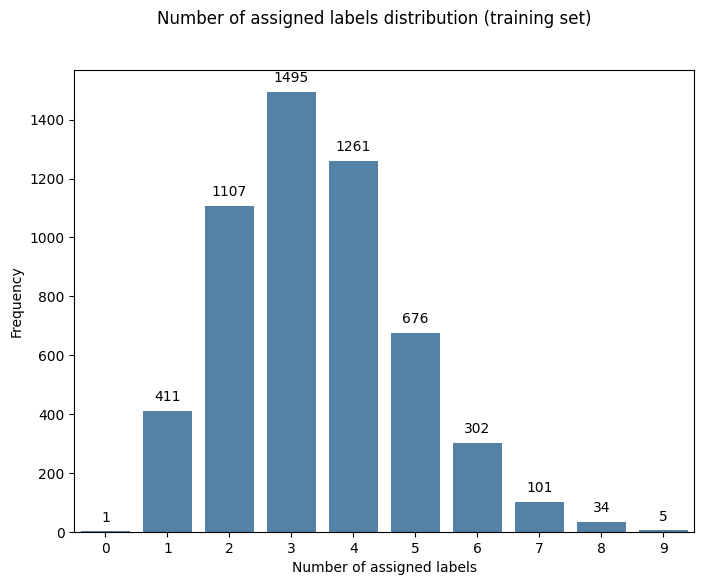

In [ ]:
fig = plt.figure(figsize=(8, 6))
fig.suptitle('Number of assigned labels distribution (training set)', fontsize=12)
ax = sns.countplot(x=labels_count, color="steelblue")

plt.xlabel('Number of assigned labels')
plt.ylabel('Frequency')

# Add numeric value count on top of each bar
for p in ax.patches:
    ax.annotate(format(p.get_height(), '.0f'), (p.get_x() + p.get_width() / 2., p.get_height()),
                ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points', fontsize=10)

plt.grid(False)
plt.show()


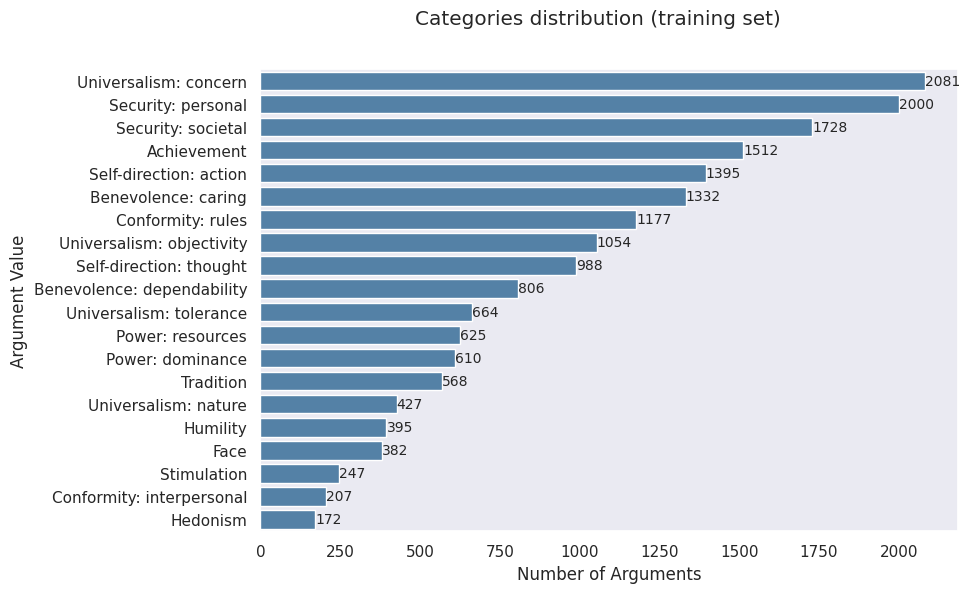

In [ ]:
# decode labels and count frequencies
label_counts = {}
for row in df_train['labels']:
    decoded_labels = decode_labels(row)
    for label in decoded_labels:
        label_counts[label] = label_counts.get(label, 0) + 1

# sort labels by number of values
sorted_labels = sorted(label_counts.items(), key=lambda x: x[1], reverse=True)

sns.set(style="darkgrid")
fig, ax = plt.subplots(figsize=(9, 6))
fig.suptitle('Categories distribution (training set)')
sns.barplot(x=[count for label, count in sorted_labels], y=[label for label, count in sorted_labels], color="steelblue", ax=ax)
ax.bar_label(ax.containers[0], fontsize=10)
plt.xlabel('Number of Arguments')
plt.ylabel('Argument Value')

plt.grid(False)
plt.show()

The plot shows that the distribution of the different class categories is clearly unbalanced. The training set contains
some samples which have no labels assigned and
therefore would not be meaningful for the task:
for this reason, they have been removed, together
with the samples with more than 7 assigned labels,
since they represent a negligible set. Afterwards, the duplicates are removed.

In [19]:
# finding rows with either zero or more than 7 labels
zero_or_many_label_idx = np.where((labels_count == 0) | (labels_count > 7))
zero_or_many_label_rows = df_train.iloc[zero_or_many_label_idx]

df_train.drop(zero_or_many_label_rows.index, inplace=True)

# dropping duplicates
df_train.drop_duplicates(subset=['Conclusion', 'Premise'],inplace = True)
print('The new training set shape is:', df_train.shape)

The new training set shape is: (5274, 5)


### **Text pre-processing**

The text pre-processing process for the SVM model consists in taking the original arguments text and applying the following steps:
1. converting to lowercase
2. removing contractions using ```contractions```library
3. removing punctuations
4. lemmatizing the sentence using ```spaCy```'s lemmatizer
5. removing stopwords provided by ```NLTK```


In [53]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [54]:
lemmatizer = spacy.load('en_core_web_sm')
STOP_WORDS = set(stopwords.words('english'))

In [55]:
def preprocess_text(text):
    """
    Given a text string, preprocesses the text by converting to lowercase, removing
    contractions, punctuations and stopwards, and lemmatizing the sentence

    :param text: Original text string

    :return: Preprocessed text string
    """
    # convert to lowercase
    text = text.lower()
    # remove contractions
    expanded_words = [contractions.fix(word) for word in text.split()]
    text = ' '.join(expanded_words)
    # remove punctuations
    text = text.translate(str.maketrans('', '', string.punctuation))
    # lemmatize
    lmt = lemmatizer(text)
    text = " ".join([token.lemma_ for token in lmt])
    # remove stopwords
    text = " ".join([word for word in text.split() if word not in STOP_WORDS])

    # pre-processed text
    return text

In [56]:
def preprocess_dataframe(df):
    '''
    Preprocesses the dataframe by applying the previous text pre-processing steps
    on the premise and conclusion"

    :param df: dataframe to preprocess

    :return: preprocessed dataframe
    '''
    df['Conclusion'] = df['Conclusion'].apply(preprocess_text)
    df['Premise'] = df['Premise'].apply(preprocess_text)

    return df

In [57]:
# pre-processing sets
df_train_prepr = preprocess_dataframe(df_train)
df_val_prepr = preprocess_dataframe(df_val)
df_test_prepr = preprocess_dataframe(df_test)

df_train_prepr.drop_duplicates(subset=['Conclusion', 'Premise'], inplace = True)
df_train_prepr.reset_index(inplace=True, drop=True)

In [58]:
df_train_prepr

,Argument ID,Conclusion,Stance,Premise,labels
0,A24197,adopt zerotolerance policy school,in favor of,security child teacher esential,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, ..."
1,A19059,adopt multiparty system,in favor of,multiparty system provide many new source view...,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
2,A27387,abolish zoo,in favor of,zoo often exhibit poor standard animal welfare...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
3,A30259,abolish intellectual property right,against,multiple reason right intellectual property ab...,"[0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ..."
4,A30032,subsidize student loan,against,student loan subsidize people choose go colleg...,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, ..."
...,...,...,...,...,...
5257,A12249,ban private military company,against,private military company provide additional so...,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, ..."
5258,A25184,adopt austerity regime,in favor of,would perhaps help country debt crisis,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, ..."
5259,A28145,ban missionary work,in favor of,missionary work preach false information unfor...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
5260,E08018,food whose production subsidize eu fund allow ...,in favor of,product come mainly large enterprise necessari...,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


### **Model 1: SVM**

The first model is **Support Vector Machine (SVM)** adapted for multi-label classification. First, a function is defined to transform the labels by binarizing them with ```MultiLabelBinarizer```.

In [59]:
def transform_labels(train_labels, val_labels, test_labels):
    """
    Converts the labels for training, validation and test sets
    binarizing them with a MultiLabelBinarizer

    :param train_labels: training set labels
    :param val_labels: validation set labels
    :param test_labels: test set labels

    :return: binarized version of the labels for each set
    """
    def binarize(labels):
      # for each category produces a list of the instances labeled with that category
      return labels.apply(lambda x: [i for i, val in enumerate(x) if val])

    train_labels = binarize(train_labels)
    val_labels = binarize(val_labels)
    test_labels = binarize(test_labels)

    mlb = MultiLabelBinarizer()
    mlb.fit(train_labels)

    mlb_train = mlb.transform(train_labels)
    mlb_val = mlb.transform(val_labels)
    mlb_test = mlb.transform(test_labels)

    return mlb_train, mlb_val, mlb_test

In [60]:
# prepare data and labels to be given to the model
X_train = df_train_prepr['Premise'] + ' ' + df_train_prepr['Stance'] + ' ' + df_train_prepr['Conclusion']
X_val = df_val_prepr['Premise'] + ' ' + df_val_prepr['Stance'] + ' ' + df_val_prepr['Conclusion']
X_test = df_test_prepr['Premise'] + ' ' + df_test_prepr['Stance'] + ' ' + df_test_prepr['Conclusion']

y_train, y_val, y_test = transform_labels(df_train_prepr['labels'], df_val_prepr['labels'], df_test_prepr['labels'])

A pipeline for SVM composed by two steps is created and trained. In the first step of the pipeline ```TfidfVectorizer``` is used, which converts the text input data into a numerical representation through a matrix of TF-IDF (Term Frequency-Inverse Document Frequency) features, which are then fed into the SVM model wrapped by ```MultiOutputClassifier```, which allows to handle multi-label classification.

In [61]:
# create and train a pipeline with TfidfVectorizer and SVM
svm = Pipeline([
    ('tfidf', TfidfVectorizer(
        min_df=0.1,
        ngram_range=(1,1),
        use_idf=1,
        smooth_idf=1,
        sublinear_tf=1)),

    ('clf', MultiOutputClassifier(
        SVC(random_state=random_seed,
        kernel='rbf',
        gamma=0.01,
        C=1.0,
        class_weight='balanced',
        max_iter = 10000)
    ))
])

svm.fit(X_train, y_train)

# make predictions on the test set
y_pred = svm.predict(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/_param_validation.py:558: FutureWarning: Passing an int for a boolean parameter is deprecated in version 1.2 and won't be supported anymore in version 1.4.
  warnings.warn(


Printing and storing the classification report metrics of SVM

In [62]:
svm_metrics = classification_report(y_test, y_pred, output_dict = True, zero_division = 1)
print(classification_report(y_test, y_pred, target_names = label_names, zero_division = 1))

                            precision    recall  f1-score   support

   Self-direction: thought       0.07      0.45      0.13       143
    Self-direction: action       0.32      0.63      0.42       391
               Stimulation       0.08      0.39      0.13        77
                  Hedonism       0.03      0.42      0.06        26
               Achievement       0.26      0.95      0.41       412
          Power: dominance       0.06      0.79      0.12       108
          Power: resources       0.07      0.45      0.12       105
                      Face       0.05      0.44      0.10        96
        Security: personal       0.35      0.99      0.51       537
        Security: societal       0.29      0.81      0.43       397
                 Tradition       0.13      0.55      0.21       168
         Conformity: rules       0.21      0.45      0.29       287
 Conformity: interpersonal       0.05      0.81      0.09        53
                  Humility       0.03      0.26

Plotting the multi-label classification confusion matrix for each human value category

In [63]:
cm = multilabel_confusion_matrix(y_test, y_pred)

In [64]:
def plot_multilabel_cm(cm, label_names):
  '''Plot the multi-label confusion matrixes

  :param cm: multi-label confusion matrix
  :param label_names: list of label names

  '''
  n_rows = 5
  n_cols = 4
  f, axes = plt.subplots(n_rows, n_cols, figsize=(15, 10))
  axes = axes.ravel()
  for i in range(len(label_names)):
      disp = ConfusionMatrixDisplay(np.array(cm[i]))
      disp.plot(ax=axes[i], cmap='Blues')
      disp.ax_.set_title(f'{label_names[i]}', fontsize=11)
      axes[i].grid(False)
      if i<len(label_names)-n_cols:
          disp.ax_.set_xlabel('')
      if i%n_cols!=0:
          disp.ax_.set_ylabel('')
      disp.im_.colorbar.remove()

  plt.subplots_adjust(wspace=0.20, hspace=0.7)
  f.colorbar(disp.im_, ax=axes)
  plt.show()

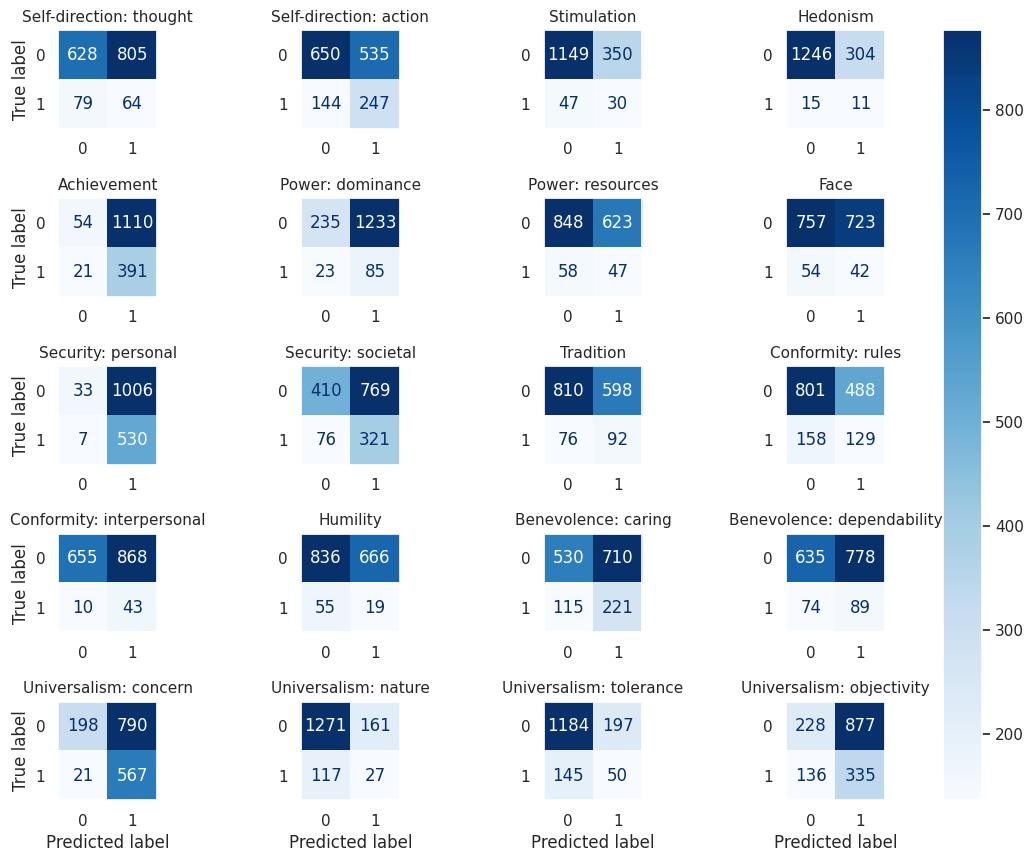

In [ ]:
plot_multilabel_cm(cm, label_names)

### **Transformer-based models**

The second approach involves the use of three transformer-based approaches:
- BERT
- XLNet
- RoBERTa

We now will define some functions to load the pre-trained models and their corresponding tokenizers, tokenize batches of data and datasets and finally to define the metrics used to evaluate the models. This is done using HuggingFace's ``transformers`` library, with PyTorch as back-end.

### Load the models and tokenizers

We load the pre-trained model through the ```from_pretrained``` function of the ```AutoModelForSequenceClassification``` model class, and we set the parameter ```problem_type``` to ```multi_label_classification``` to adapt the problem to multi-label classification, as this will make sure the appropriate loss function is used (namely ```BCEWithLogitsLoss```). We also make sure the output layer has ```len(label_names)``` output neurons (20 human value categories), and we set the ```id2label``` and ```label2id``` mappings.

In [20]:
def load_model_tokenizer(model_name):
  """
  Loads and configures a pretrained model via HuggingFace transformers
  library with the corresponding tokenizer

  :param model_name: name of the model to load

  :return:
    - model: pretrained  transformer model
    - tokenizer: model's tokenizer

  """
  id2label = {}
  label2id = {}

  for idx, label in enumerate(label_names):
      id2label[idx] = label
      label2id[label] = idx

  # load pre-trained model, adapted for multi-label classification
  model = AutoModelForSequenceClassification.from_pretrained(model_name,
                                                             problem_type="multi_label_classification",
                                                             output_hidden_states=False,
                                                             num_labels=len(label_names),
                                                             id2label=id2label,
                                                             label2id=label2id).to(device)
  # load tokenizer
  tokenizer = AutoTokenizer.from_pretrained(model_name)

  model.config.early_stopping = True
  model.config.cls_token_id = tokenizer.cls_token_id
  model.config.eos_token_id = tokenizer.sep_token_id
  model.config.pad_token_id = tokenizer.pad_token_id

  return model, tokenizer

### Dataset Tokenization

In [21]:
def process_data_to_model_inputs(batch, tokenizer):
  '''
  Tokenizes a batch of data

  :param batch: batch of data to tokenize
  :param tokenizer: model tokenizer

  :return batch: batch of tokenized data
  '''
  input = []
  for conclusion, stance, premise in zip(batch["Conclusion"], batch["Stance"], batch["Premise"]):
    input.append(premise + ' ' + tokenizer.sep_token + ' ' + stance + ' ' +
                  tokenizer.sep_token + ' ' + conclusion)

  inputs = tokenizer(input, padding="max_length", truncation="longest_first", max_length=128)

  batch["input_ids"] = inputs.input_ids
  batch["attention_mask"] = inputs.attention_mask

  return batch

In [22]:
def tokenize_dataset(df, tokenizer):
  '''
  Tokenizes an entire dataset

  :param df: the dataframe to be tokenized
  :param tokenizer: model tokenizer

  :return df_tok: tokenized dataset
  '''
  df_tok = datasets.Dataset.from_pandas(df)
  col_names = [f for f in df_tok.features if f != 'labels']

  # dataframe tokenization by map function
  df_tok = df_tok.map(
        process_data_to_model_inputs,
        fn_kwargs={"tokenizer": tokenizer},
        batched=True,
        batch_size=BATCH_SIZE,
        remove_columns=col_names
      )

  # converts the labels to a sequence of float32 values
  df_tok = df_tok.cast_column("labels", Sequence(Value("float32")))
  df_tok.set_format(type="torch", device = device, columns=["input_ids", "attention_mask", "labels"])

  return df_tok

### Metric functions

As for model training evaluation, we define the metrics used and adapted for the multi-label classification task, which is macro F1-score. In particular, we use the Pytorch sigmoid function with a default threshold set to 0.5, meaning that all values above are assigned a value of 1.

In [23]:
def multi_label_metrics(predictions, labels, threshold = 0.5):
    '''
    Computes F1 score for multi-label tasks.

    :param predictions: predicted logits from the model
    :param labels: ground-truth values
    :param threshold: threshold applied to convert from probability to binary array

    :return a dictionary containing the computed F1 score
    '''
    # apply sigmoid on predictions which are of shape (batch_size, num_labels)
    # to convert from logit to probability
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # use threshold to turn them into integer predictions (binary array)
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    # return as dictionary
    metrics = {'macro f1': f1_macro_average}
    return metrics

def compute_metrics(p: EvalPrediction):
    '''
    Computes the F1 score value for a batch of predictions

    :param EvalPrediction: the predicted labels

    :return a dictionary containing the computed F1 score for the entire batch
    '''
    preds = p.predictions[0] if isinstance(p.predictions,tuple) else p.predictions
    result = multi_label_metrics(predictions=preds,labels=p.label_ids)
    return result

### Evaluation functions

Some utility functions for the models evaluation are defined, in particular for generating predictions, computing evaluation metrics (using sklearn ```classification_report```) and for computing the best thresholds for each category which maximises each F1-score.

In [24]:
def generate_batch_predictions(batch, model, tokenizer, threshold):
  '''
  Generates classification predictions for a batch of inputs

  :param batch: batch of input data
  :param model: model that will be used for predictions
  :param tokenizer: model tokenizer
  :param threshold: threshold applied to convert from probability to binary array

  :return batch: batch extended with the predicted labels as binary array
                    and the corresponding probability as float
  '''
  outputs = model(batch['input_ids'], attention_mask=batch['attention_mask']).logits.tolist()

  sigmoid = torch.nn.Sigmoid()
  probs = sigmoid(torch.Tensor(outputs))
  pred_labels = np.where(np.array(probs) > threshold, 1, 0)

  batch["predictions"] = pred_labels
  batch["probabilities"] = probs

  return batch

In [25]:
def compute_evaluation_results(model, tokenizer, df, threshold = 0.5):
    '''
    :param model: model used for predictions
    :param tokenizer: model tokenizer
    :param df: dataframe used for evaluation
    :param threshold: threshold applied to convert from probability to binary array
                      (default set to 0.5)

    :return
      - model_result: Dataset object containing the predictions as binary array and corresponding probabilities
    '''
    model_result = df.map(generate_batch_predictions,
                             fn_kwargs={"model": model, "tokenizer": tokenizer, "threshold" : threshold},
                             batched=True,
                             batch_size=BATCH_SIZE,
                             remove_columns=['input_ids', 'attention_mask'])

    return model_result

In [26]:
def compute_best_thresholds(model, tokenizer):
    '''
    Computes the best threshold for each category to maximize each F1-score
    for a given model

    :param model: model used for predictions
    :param tokenizer: model tokenizer

    :return best_thresholds: dictionary of best thresholds
    '''
    # tokenize the train+val dataframe and compute evaluation metrics
    df_concat = pd.concat([df_train, df_val], axis = 0)
    df_concat_tok = tokenize_dataset(df_concat, tokenizer)
    df_concat_results = compute_evaluation_results(model, tokenizer, df_concat_tok)

    probabilities = df_concat_results['probabilities'].cpu().data.numpy()
    labels = df_concat_results['labels'].cpu().data.numpy()

    best_thresholds = {}
    for label_idx, label_name in enumerate(label_names):
        label_probs = probabilities[:, label_idx]
        label_true = labels[:, label_idx]

        # range of threshold values
        thresholds = np.linspace(0.01, 0.5, 50)
        best_f1_score = 0.0   # best f1 score found
        best_threshold = 0.5  # initial threshold value

        for threshold in thresholds:
            # convert probabilities to binary labels based on the threshold
            label_pred = np.where(label_probs > threshold, 1, 0)
            # compute F1 score for the current threshold
            f1 = f1_score(label_true, label_pred, zero_division=1)
            if f1 > best_f1_score:
                best_f1_score = f1
                best_threshold = threshold

        best_thresholds[label_name] = best_threshold

    best_thresholds = {k: round(v, 2) for k, v in best_thresholds.items()}

    for label_name, threshold in best_thresholds.items():
      print(f"Best threshold found for category {label_name} = {threshold}")
    print()

    return best_thresholds

In [27]:
def compute_model_report(model, tokenizer, df_output, best_thresholds):
    '''
    Computes and prints the model's classification report using the best thresholds

    :param model: model used for predictions
    :param tokenizer: model tokenizer
    :param df_output: computed df with predictions for evaluation
    :param best_thresholds: dictionary containing the best thresholds for each category

    :return model_results: classification report for a given model
    '''

    probabilities = df_output['probabilities'].cpu().data.numpy()
    labels = df_output['labels'].cpu().data.numpy()

    # apply the best thresholds obtained for each category through a binary array
    probabilities = np.where(probabilities >= np.array(list(best_thresholds.values())), 1, 0)

    print(sklearn.metrics.classification_report(labels, probabilities, target_names=label_names))
    model_results = sklearn.metrics.classification_report(labels, probabilities, output_dict=True, zero_division=1)

    return model_results

In [28]:
num_train_epochs = 8

### **Model 2: BERT-base-uncased**

Parameters used for `bert-base-uncased`:
- Batch size: 32
- Learning rate: 5e-5
- Optimizer: AdamW
- Weight Dcay: 0.01
- Number of epochs: 8

In [33]:
BATCH_SIZE = 32
model_name = 'bert-base-uncased'

In [34]:
training_checkpoint_path = drive_path + "/checkpoint/" + model_name
save_model_path = drive_path + "/trained_model/" + model_name


training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    learning_rate=5e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True,
    logging_steps= len(df_train) // BATCH_SIZE,
    output_dir = training_checkpoint_path,
    optim='adamw_torch',
    report_to ='all',
)

model, tokenizer = load_model_tokenizer(model_name)

df_train_tok = tokenize_dataset(df_train, tokenizer)
df_val_tok = tokenize_dataset(df_val, tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer= tokenizer,
    train_dataset=df_train_tok,
    eval_dataset=df_val_tok,
  )

trainer.train()
trainer.save_model(save_model_path)

del model
torch.cuda.empty_cache()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Map:   0%|          | 0/5274 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5274 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1896 [00:00<?, ? examples/s]

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro f1
1,0.409800,0.369595,0.131103
2,0.330000,0.338716,0.291091
3,0.287000,0.336260,0.331872
4,0.249600,0.334997,0.355853
5,0.217500,0.339361,0.354442
6,0.190900,0.349203,0.367490
7,0.172700,0.354313,0.368731
8,0.160300,0.354819,0.365836


Loading the model and evaluating it, storing its results

In [35]:
model_name = 'bert-base-uncased'
save_model_path = drive_path + "/trained_model/" + model_name

model = AutoModelForSequenceClassification.from_pretrained(save_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Computing and printing the best thresholds for each category and later evaluating on the test set, saving the model's metrics.

In [36]:
# computing best threshold for each category
best_thresholds = compute_best_thresholds(model, tokenizer)

# evaluation
df_test_tokenized = tokenize_dataset(df_test, tokenizer)
df_output = compute_evaluation_results(model, tokenizer, df_test_tokenized)

# saving model's metrics
bert_metrics = compute_model_report(model, tokenizer, df_output, best_thresholds)

Map:   0%|          | 0/7170 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7170 [00:00<?, ? examples/s]

Map:   0%|          | 0/7170 [00:00<?, ? examples/s]

Best threshold found for category Self-direction: thought = 0.47
Best threshold found for category Self-direction: action = 0.38
Best threshold found for category Stimulation = 0.27
Best threshold found for category Hedonism = 0.3
Best threshold found for category Achievement = 0.45
Best threshold found for category Power: dominance = 0.27
Best threshold found for category Power: resources = 0.46
Best threshold found for category Face = 0.19
Best threshold found for category Security: personal = 0.41
Best threshold found for category Security: societal = 0.48
Best threshold found for category Tradition = 0.35
Best threshold found for category Conformity: rules = 0.38
Best threshold found for category Conformity: interpersonal = 0.25
Best threshold found for category Humility = 0.24
Best threshold found for category Benevolence: caring = 0.34
Best threshold found for category Benevolence: dependability = 0.29
Best threshold found for category Universalism: concern = 0.47
Best threshold 

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

                            precision    recall  f1-score   support

   Self-direction: thought       0.57      0.44      0.50       143
    Self-direction: action       0.64      0.57      0.60       391
               Stimulation       0.42      0.06      0.11        77
                  Hedonism       0.44      0.15      0.23        26
               Achievement       0.61      0.49      0.54       412
          Power: dominance       0.33      0.36      0.35       108
          Power: resources       0.45      0.40      0.42       105
                      Face       0.16      0.15      0.15        96
        Security: personal       0.71      0.78      0.74       537
        Security: societal       0.58      0.61      0.60       397
                 Tradition       0.50      0.39      0.44       168
         Conformity: rules       0.50      0.50      0.50       287
 Conformity: interpersonal       0.29      0.13      0.18        53
                  Humility       0.13      0.07

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Model 3: XLNet-base**

Parameters used for `xlnet-base-cased`:
- Batch size: 32
- Learning rate: 2e-5
- Optimizer: AdamW
- Weight Dcay: 0.01
- Number of epochs: 8

In [37]:
BATCH_SIZE = 32
model_name = 'xlnet-base-cased'

In [38]:
training_checkpoint_path = drive_path + "/checkpoint/" + model_name
save_model_path = drive_path + "/trained_model/" + model_name

training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True,
    logging_steps= len(df_train) // BATCH_SIZE,
    output_dir = training_checkpoint_path,
    optim='adamw_torch',
    report_to ='all',
)

model, tokenizer = load_model_tokenizer(model_name)

df_train_tok = tokenize_dataset(df_train, tokenizer)
df_val_tok = tokenize_dataset(df_val, tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer= tokenizer,
    train_dataset=df_train_tok,
    eval_dataset=df_val_tok,
  )

trainer.train()
trainer.save_model(save_model_path)

del model
torch.cuda.empty_cache()

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.weight', 'sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

Map:   0%|          | 0/5274 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5274 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1896 [00:00<?, ? examples/s]

You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro f1
1,0.412700,0.380794,0.108223
2,0.344900,0.345886,0.250381
3,0.312900,0.333012,0.297058
4,0.291200,0.327834,0.324264
5,0.274700,0.328532,0.329302
6,0.260700,0.325935,0.358709
7,0.251100,0.327374,0.359354
8,0.243300,0.327406,0.358592


Loading the model and evaluating it, storing its results

In [39]:
model_name = 'xlnet-base-cased'
save_model_path = drive_path + "/trained_model/" + model_name

model = AutoModelForSequenceClassification.from_pretrained(save_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Computing and printing the best thresholds for each category and later evaluating on the test set, saving the model's metrics.

In [40]:
# computing best threshold for each category
best_thresholds = compute_best_thresholds(model, tokenizer)

# evaluation
df_test_tokenized = tokenize_dataset(df_test, tokenizer)
df_output = compute_evaluation_results(model, tokenizer, df_test_tokenized)

# saving model's metrics
xlnet_metrics = compute_model_report(model, tokenizer, df_output, best_thresholds)

Map:   0%|          | 0/7170 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7170 [00:00<?, ? examples/s]

Map:   0%|          | 0/7170 [00:00<?, ? examples/s]

Best threshold found for category Self-direction: thought = 0.47
Best threshold found for category Self-direction: action = 0.36
Best threshold found for category Stimulation = 0.18
Best threshold found for category Hedonism = 0.22
Best threshold found for category Achievement = 0.32
Best threshold found for category Power: dominance = 0.19
Best threshold found for category Power: resources = 0.4
Best threshold found for category Face = 0.16
Best threshold found for category Security: personal = 0.49
Best threshold found for category Security: societal = 0.38
Best threshold found for category Tradition = 0.36
Best threshold found for category Conformity: rules = 0.3
Best threshold found for category Conformity: interpersonal = 0.18
Best threshold found for category Humility = 0.17
Best threshold found for category Benevolence: caring = 0.31
Best threshold found for category Benevolence: dependability = 0.22
Best threshold found for category Universalism: concern = 0.39
Best threshold f

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

                            precision    recall  f1-score   support

   Self-direction: thought       0.46      0.50      0.48       143
    Self-direction: action       0.65      0.61      0.63       391
               Stimulation       0.16      0.10      0.13        77
                  Hedonism       0.13      0.23      0.17        26
               Achievement       0.59      0.56      0.57       412
          Power: dominance       0.35      0.31      0.33       108
          Power: resources       0.47      0.40      0.43       105
                      Face       0.22      0.21      0.21        96
        Security: personal       0.71      0.77      0.74       537
        Security: societal       0.52      0.76      0.62       397
                 Tradition       0.52      0.42      0.47       168
         Conformity: rules       0.44      0.62      0.52       287
 Conformity: interpersonal       0.18      0.09      0.12        53
                  Humility       0.07      0.09

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### **Model 4: RoBERTa-base**

Parameters used for `roberta-base`:
- Batch size: 16
- Learning rate: 2e-5
- Optimizer: AdamW
- Weight Dcay: 0.01
- Number of epochs: 8

In [47]:
BATCH_SIZE = 16
model_name = 'roberta-base'

In [48]:
training_checkpoint_path = drive_path + "/checkpoint/" + model_name
save_model_path = drive_path + "/trained_model/" + model_name


training_args = TrainingArguments(
    evaluation_strategy="epoch",
    save_strategy="no",
    num_train_epochs=num_train_epochs,
    weight_decay=0.01,
    learning_rate=2e-5,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    fp16=True,
    logging_steps= len(df_train) // BATCH_SIZE,
    output_dir = training_checkpoint_path,
    optim='adamw_torch',
    report_to ='all',
)

model, tokenizer = load_model_tokenizer(model_name)

df_train_tok = tokenize_dataset(df_train, tokenizer)
df_val_tok = tokenize_dataset(df_val, tokenizer)

trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    tokenizer= tokenizer,
    train_dataset=df_train_tok,
    eval_dataset=df_val_tok,
  )

trainer.train()
trainer.save_model(save_model_path)

del model
torch.cuda.empty_cache()

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.weight', 'lm_head.dense.bias', 'lm_head.bias', 'roberta.pooler.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.out_proj.weight', 'classi

Map:   0%|          | 0/5274 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/5274 [00:00<?, ? examples/s]

Map:   0%|          | 0/1896 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1896 [00:00<?, ? examples/s]

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Macro f1
1,0.398900,0.348553,0.198855
2,0.322400,0.331486,0.300816
3,0.290900,0.326869,0.344730
4,0.267300,0.320955,0.351153
5,0.248300,0.319806,0.355929
6,0.233100,0.322964,0.389094
7,0.222100,0.325607,0.380464
8,0.213800,0.325321,0.384943


In [49]:
model_name = 'roberta-base'
save_model_path = drive_path + "/trained_model/" + model_name

model = AutoModelForSequenceClassification.from_pretrained(save_model_path).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)

Loading the model and evaluating it, storing its results

Computing and printing the best thresholds for each category and later evaluating on the test set, saving the model's metrics.

In [50]:
# computing best threshold for each category
best_thresholds = compute_best_thresholds(model, tokenizer)

# tokenizing test set for evaluation
df_test_tokenized = tokenize_dataset(df_test, tokenizer)
df_output = compute_evaluation_results(model, tokenizer, df_test_tokenized)

# saving model's metrics
roberta_metrics = compute_model_report(model, tokenizer, df_output, best_thresholds)

Map:   0%|          | 0/7170 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/7170 [00:00<?, ? examples/s]

Map:   0%|          | 0/7170 [00:00<?, ? examples/s]

Best threshold found for category Self-direction: thought = 0.49
Best threshold found for category Self-direction: action = 0.36
Best threshold found for category Stimulation = 0.18
Best threshold found for category Hedonism = 0.26
Best threshold found for category Achievement = 0.38
Best threshold found for category Power: dominance = 0.26
Best threshold found for category Power: resources = 0.39
Best threshold found for category Face = 0.17
Best threshold found for category Security: personal = 0.45
Best threshold found for category Security: societal = 0.46
Best threshold found for category Tradition = 0.35
Best threshold found for category Conformity: rules = 0.34
Best threshold found for category Conformity: interpersonal = 0.25
Best threshold found for category Humility = 0.25
Best threshold found for category Benevolence: caring = 0.34
Best threshold found for category Benevolence: dependability = 0.25
Best threshold found for category Universalism: concern = 0.43
Best threshold

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/1576 [00:00<?, ? examples/s]

Map:   0%|          | 0/1576 [00:00<?, ? examples/s]

                            precision    recall  f1-score   support

   Self-direction: thought       0.54      0.54      0.54       143
    Self-direction: action       0.65      0.63      0.64       391
               Stimulation       0.27      0.13      0.18        77
                  Hedonism       0.54      0.27      0.36        26
               Achievement       0.61      0.54      0.57       412
          Power: dominance       0.37      0.34      0.36       108
          Power: resources       0.45      0.39      0.42       105
                      Face       0.21      0.17      0.19        96
        Security: personal       0.73      0.76      0.75       537
        Security: societal       0.63      0.64      0.64       397
                 Tradition       0.53      0.60      0.56       168
         Conformity: rules       0.54      0.53      0.54       287
 Conformity: interpersonal       0.53      0.19      0.28        53
                  Humility       0.07      0.07

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Error analysis

Some random examples of predictions are shown to evaluate and analyze the errors produced by the models, particularly on labels with lowest support

In [ ]:
def create_prediction_df(df_output, tokenizer, decode_labels):
    prediction_df = pd.DataFrame(columns=['Input', 'Ground Truth Labels', 'Predicted Labels'])

    # Number of arguments to show
    n_args = 5
    args = random.sample(range(1, len(df_output)), n_args)

    for arg_idx in args:
        row = df_output[arg_idx]
        input_ids = row['input_ids'].cpu().data.numpy()
        labels = row['labels'].cpu().data.numpy()
        predictions = row['predictions'].cpu().data.numpy()
        input_str = tokenizer.decode(input_ids, skip_special_tokens=True)

        temp_df = pd.DataFrame({'Input': [input_str],
                                'Ground Truth Labels': [decode_labels(labels)],
                                'Predicted Labels': [decode_labels(predictions)]})

        prediction_df = pd.concat([prediction_df, temp_df], ignore_index=True)

    return prediction_df

In [ ]:
# to show the entire input arguments and predicted labels
pd.set_option('display.max_colwidth', None)

In [ ]:
prediction_df = create_prediction_df(df_output, tokenizer, decode_labels)
prediction_df

,Input,Ground Truth Labels,Predicted Labels
0,woman prohibit combat overmatche average man fight in favor of prohibit woman combat,[Achievement],[Universalism: concern]
1,prisoner hold guantanamo bay big threat world must detain deal completely different way rest population safety against close guantanamo bay detention camp,"[Security: societal, Universalism: concern]","[Security: societal, Universalism: concern]"
2,time stop use animal entertainment purpose in favor of ban wild animal circus,[Universalism: nature],[Universalism: nature]
3,affirmative action may lead reverse discrimination detriment nonbeneficiary party in favor of end affirmative action,[Universalism: concern],[Universalism: concern]
4,racial profiling effective potential criminal stop commit crime against end racial profiling,"[Achievement, Power: dominance, Security: societal]","[Security: societal, Conformity: rules, Universalism: concern]"


The table shows different examples of input arguments with the corresponding ground truth labels and predicted labels. It is worth noting that, despite most of the predicted labels are correct, there are some which are missing and were not recognized by the model. In particular, it is likely that the missing or wrong human value categories are the ones with lower support, since the models struggle with their classification, and this is confirmed by the low F1 scores achieved by the models.

### Models' comparison

In [51]:
def plot_models_statistics_f1(models, label_names):
    '''
    Plots a graphical representation showing the performance of the different models
    in terms of F1-score achieved across the various categories, along with their support.

    :param models: a dictionary of the models names and their corresponding metrics
    :param label_names: the list of category label names

    '''
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    num_labels = len(label_names)
    x = np.arange(num_labels)

    fig, ax = plt.subplots(figsize=(12, 4))
    for i, (model_name, model_results) in enumerate(models.items()):
        f1_scores = [model_results[str(j)]['f1-score'] for j in range(num_labels)]
        supports = [model_results[str(j)]['support'] for j in range(num_labels)]

        ax.plot(x, f1_scores, '-o', color=colors[i], label=model_name)
        ax.bar(x, [s / sum(supports) for s in supports], color='steelblue')

    ax.set_xlabel('Labels')
    ax.set_ylabel('F1-score')
    ax.set_xticks(x)
    ax.set_xticklabels(label_names, rotation=45, ha='right', rotation_mode='anchor')
    ax.set_yticks(np.linspace(0, 1, num=11))
    ax.tick_params(labelleft=True)
    ax.legend()

    plt.show()

In [65]:
models_metrics_dict = {'SVM': svm_metrics, 'BERT':bert_metrics, 'XLNet': xlnet_metrics, 'RoBERTa': roberta_metrics}

Comparison of the F1-score achieved by SVM, BERT, RoBERTa and XLNet on the 20 human categories with their corresponding support

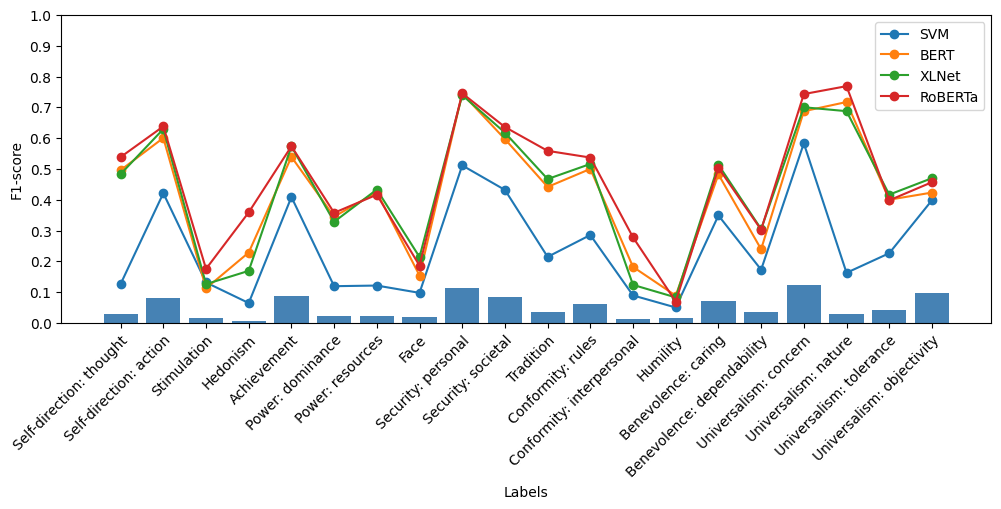

In [66]:
plot_models_statistics_f1(models_metrics_dict, label_names)

### Final considerations

The models comparison of the F1 scores shows that there is a correlation between the F1 score and the support of the human value categories: a higher support leads to higher F1 scores and, inversely, a lower support leads to lower F1 scores. However, there are a few exceptions, such as Power: dominance, Power: resources, Tradition and Universalism: nature, where the F1-score is high despite the low support. This may be due to the fact that these categories contain instances with words or phrases that are particularly informative, allowing the models to accurately discriminate and classify these categories.

The results of the experiments show that transformer-based models such as BERT, XLNet and RoBERTa outperform traditional machine learning models like SVM. Indeed, SVM achieved a final macro F1-score of 0.25, which is significantly lower than the top-performing model, RoBERTa, which instead achieved a macro F1-score of 0.46. Further experiments may involve considering only a subset of the human value categories and experimenting with data augmentation techniques in order to mitigate the class imbalance issue, as well as with transformer-based models of larger complexity.